## Урок 6. Домашнее задание

Импортируем необходимые библиотеки и воспользуемся кодом с урока для определения метрики, которая будет использоваться при обучении в дальнейшем.

In [108]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
import os
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

# метрика Dice Coefficient

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

Будем работать с датасетом `Cityscapes`. В данном датасете присутствуют исходные и сегментированные изображения. Для построения нейросети нам нужно создать размеченные изображения, на каждом из которых будет присутствовать только один класс.

In [109]:
# Будем работать только с частью датасета, так как ресурсы на Kaggle ограничены
num_images_train = 80
num_images_val = 20


X_train = []
y_train = []

X_val = []
y_val = []


image_dir_train = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/train'
image_dir_val = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val'
images_train = os.listdir(image_dir_train)
images_val = os.listdir(image_dir_val)

for filename in images_train[:num_images_train]:
    image = Image.open(os.path.join(image_dir_train, filename))
#     X_train.append(ImageOps.crop(image, (0, 0, 256, 0)))
#     y_train.append(ImageOps.crop(image, (256, 0, 0, 0)))
    X_train.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    y_train.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))
    

for filename in images_val[:num_images_val]:
    image = Image.open(os.path.join(image_dir_val, filename))
    X_val.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    y_val.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))


X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.

y_train = np.array(y_train)
y_val = np.array(y_val)

Построим сегментированные изображения с помощью кластеризации и затем сформируем датасет для обучения. Будем разбивать на 19 классов, так как насколько я понял из данного файла https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py в датасете 19 основных типов объектов.

In [124]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
num_classes = 19
label_model = KMeans(n_clusters=num_classes, random_state=21)
label_model.fit(color_array)

KMeans(n_clusters=19, random_state=21)

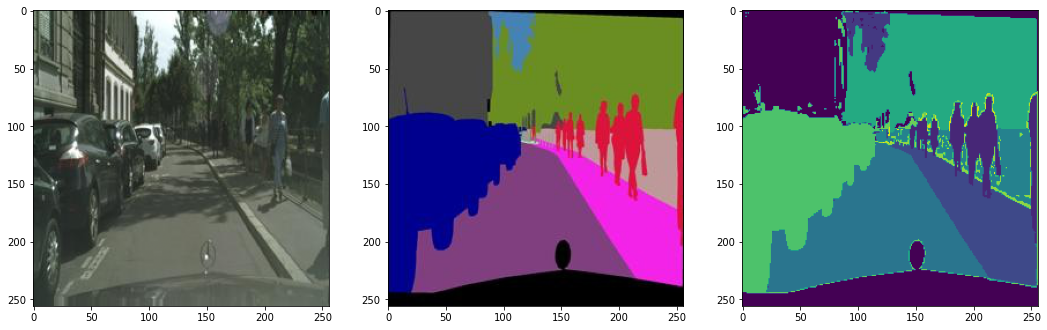

In [126]:
label_class = label_model.predict(y_train[3].reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(18, 9))
axes[0].imshow(X_train[3])
axes[1].imshow(y_train[3])
axes[2].imshow(label_class)
plt.show()

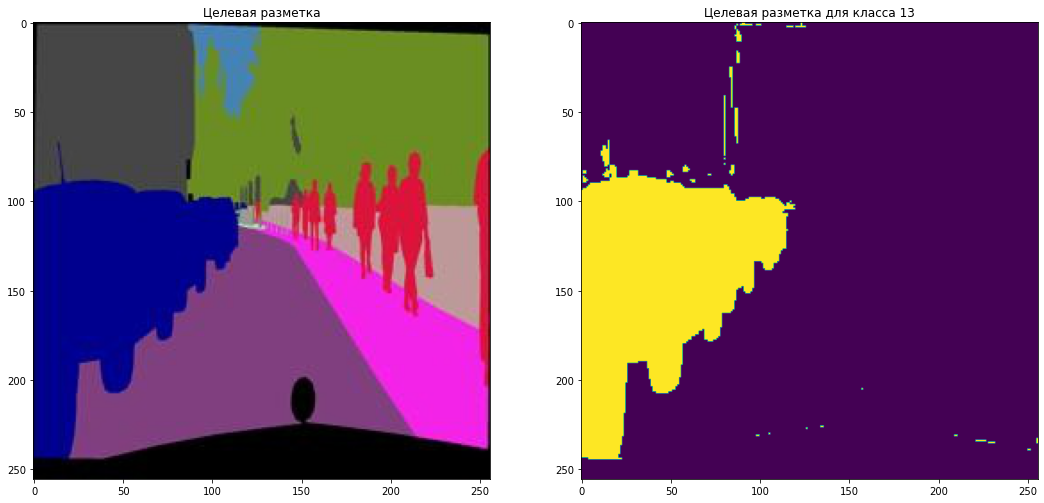

In [128]:
def Color2index(y, num_classes=19):
    arr_col = np.arange(0, num_classes)
    t = label_model.predict(y.reshape(-1, 3)).reshape(256, 256)
    y_cat = (arr_col == t[...,None]).astype(int)
    return y_cat, t

cat_yi,ind_yi = Color2index(y_train[3])

class_ = 13
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
axes[0].imshow(y_train[3,:,:,:])
axes[0].title.set_text('Целевая разметка')
axes[1].imshow(cat_yi[:,:,class_])
axes[1].title.set_text(f'Целевая разметка для класса {class_}')
plt.show() 

Сформируем наборы выходных примеров для обучения и валидации.

In [129]:
train_labels = []
val_labels = []

for mask in y_train:
    y_cat,_ = Color2index(mask)
    train_labels.append(y_cat)


for mask in y_val:
    y_cat,_ = Color2index(mask)
    val_labels.append(y_cat)
    
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [130]:
train_labels.shape

(80, 256, 256, 19)

Попробуем взять сеть с урока, немного адаптировав под условия задачи и увеличив количество эпох.

In [131]:
def Unet(num_classes = 19, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) 

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_214 (BatchN (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_214 (Activation)     (None, 256, 256, 64) 0           batch_normalization_214[0][0]    
___________________________________________________________________________________________

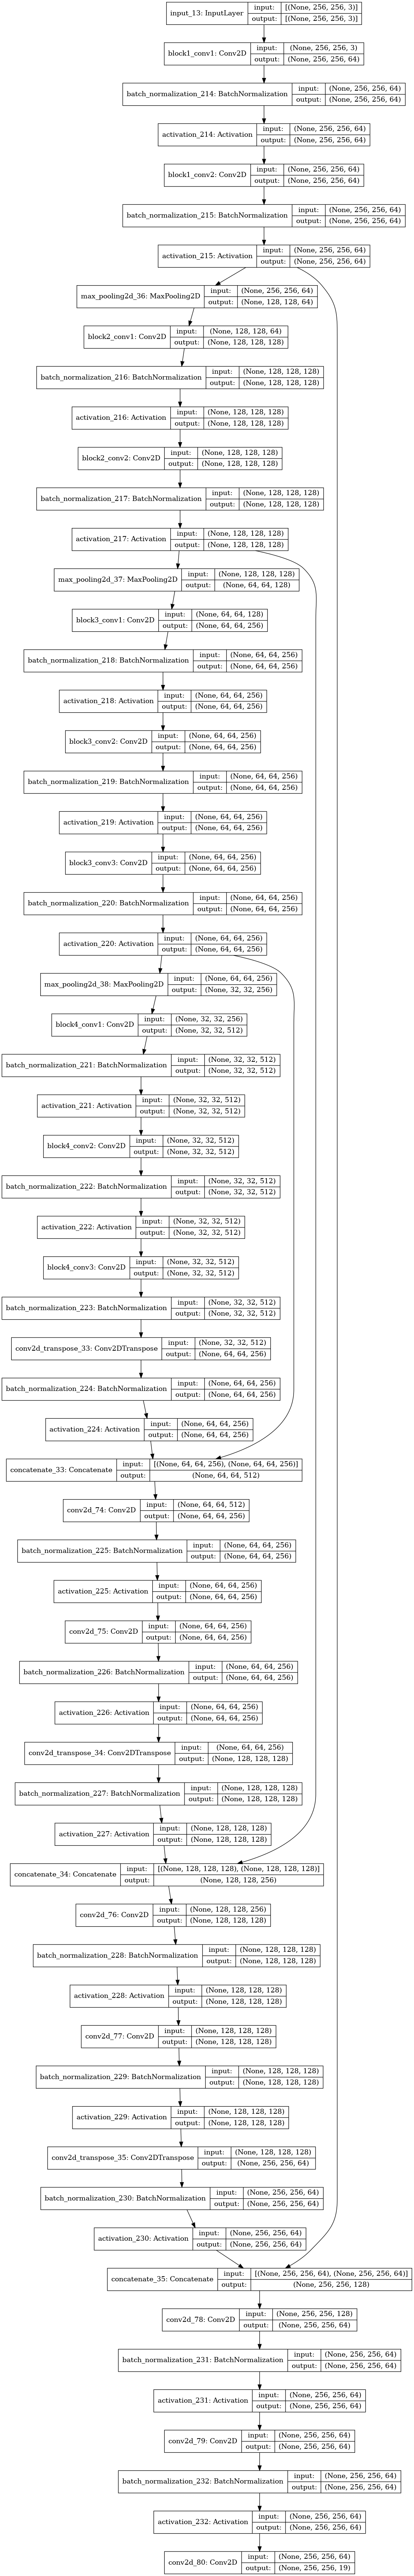

In [132]:
model_1 = Unet(19, (256, 256, 3))

plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [133]:
history = model_1.fit(X_train, train_labels, epochs=25, batch_size=1, validation_data=(X_val, val_labels))

Epoch 1/25
80/80 [==============================] - 7s 54ms/step - loss: 1.4255 - dice_coef: 0.4232 - val_loss: 15.0726 - val_dice_coef: 0.3606
Epoch 2/25
80/80 [==============================] - 4s 47ms/step - loss: 1.1780 - dice_coef: 0.4927 - val_loss: 10.6058 - val_dice_coef: 0.3656
Epoch 3/25
80/80 [==============================] - 4s 48ms/step - loss: 1.0902 - dice_coef: 0.5236 - val_loss: 13.2848 - val_dice_coef: 0.3917
Epoch 4/25
80/80 [==============================] - 4s 47ms/step - loss: 1.0263 - dice_coef: 0.5445 - val_loss: 9.7118 - val_dice_coef: 0.4064
Epoch 5/25
80/80 [==============================] - 4s 47ms/step - loss: 1.0197 - dice_coef: 0.5569 - val_loss: 4.7399 - val_dice_coef: 0.4006
Epoch 6/25
80/80 [==============================] - 4s 47ms/step - loss: 0.9661 - dice_coef: 0.5689 - val_loss: 2.4816 - val_dice_coef: 0.4991
Epoch 7/25
80/80 [==============================] - 4s 48ms/step - loss: 0.9450 - dice_coef: 0.5825 - val_loss: 2.1262 - val_dice_coef: 0.4

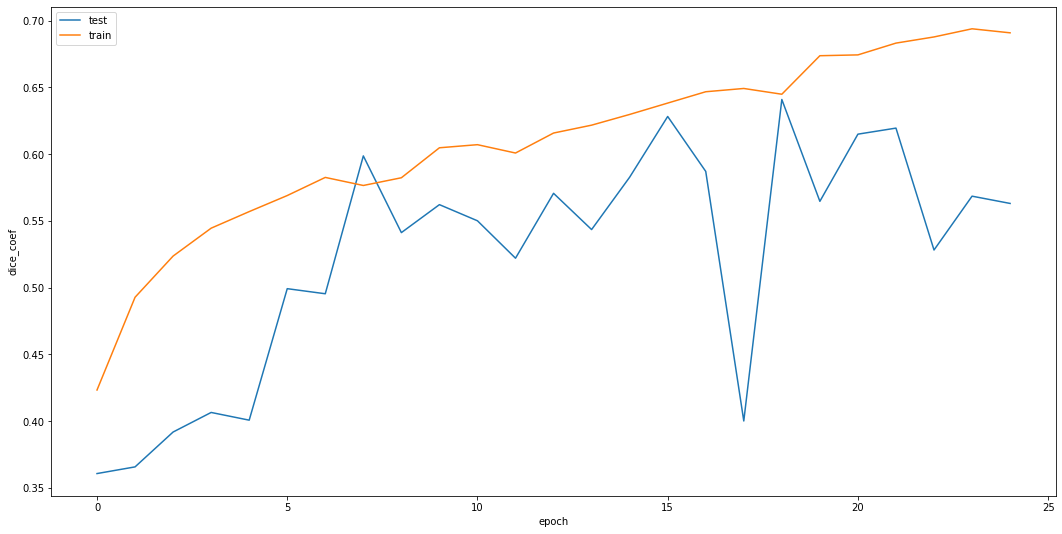

In [134]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Видим, что метрика на тесте ведет себя очень нестабильно, в то время как на трейне метрика растет, что в конечном итоге на более поздних эпохах ведет к заметному переобучению. Посмотрим насколько хорошо получается разметка для отдельных классов.

In [137]:
pred = model_1.predict(X_val)
print(pred.shape)

(20, 256, 256, 19)


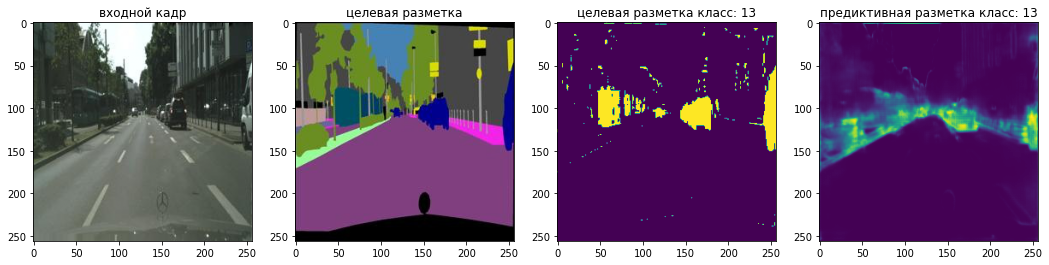

In [139]:
class_ = 13
fig, axes = plt.subplots(1, 4, figsize=(18, 9))
axes[0].imshow(X_val[5])
axes[0].title.set_text('входной кадр')
axes[1].imshow(y_val[5])
axes[1].title.set_text('целевая разметка')
axes[2].imshow(val_labels[5][:,:,class_])
axes[2].title.set_text(f'целевая разметка класс: {class_}')
axes[3].imshow(pred[5][:,:,class_])
axes[3].title.set_text(f'предиктивная разметка класс: {class_}')
plt.show()

Попробуем улучшить модель:

* изменим функцию активации;
* добавим специфичное определение начальных весов;
* изменим оптимизатор и зададим коэффициент скорости обучения;
* увеличим количество эпох обучения.

In [142]:
def Unet(num_classes = 19, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_3_out) 

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('LeakyReLU')(x)

#     x = MaxPooling2D()(block_4_out)

#     Block 5
#     x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
#     x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = concatenate([x, block_4_out])
#     x = Conv2D(512, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(512, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=SGD(learning_rate=1e-2),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [143]:
model_2 = Unet(19, (256, 256, 3))

# plot_model(model_2, to_file='model_2.png', show_shapes=True)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_252 (BatchN (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_252 (Activation)     (None, 256, 256, 64) 0           batch_normalization_252[0][0]    
___________________________________________________________________________________________

In [144]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('seg_model.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience)
    callbacks_list=[checkpoint, early]
    return callbacks_list


history = model_2.fit(X_train, train_labels, epochs=50, batch_size=1, validation_data=(X_val, val_labels), callbacks=callbacks())

Epoch 1/50
80/80 [==============================] - 7s 55ms/step - loss: 1.8299 - dice_coef: 0.3148 - val_loss: 2.2620 - val_dice_coef: 0.1615

Epoch 00001: loss improved from inf to 1.82991, saving model to seg_model.h5
Epoch 2/50
80/80 [==============================] - 4s 49ms/step - loss: 1.3151 - dice_coef: 0.4629 - val_loss: 2.4117 - val_dice_coef: 0.3109

Epoch 00002: loss improved from 1.82991 to 1.31515, saving model to seg_model.h5
Epoch 3/50
80/80 [==============================] - 4s 47ms/step - loss: 1.1786 - dice_coef: 0.5090 - val_loss: 2.5408 - val_dice_coef: 0.3747

Epoch 00003: loss improved from 1.31515 to 1.17864, saving model to seg_model.h5
Epoch 4/50
80/80 [==============================] - 4s 47ms/step - loss: 1.1046 - dice_coef: 0.5376 - val_loss: 1.9912 - val_dice_coef: 0.4459

Epoch 00004: loss improved from 1.17864 to 1.10458, saving model to seg_model.h5
Epoch 5/50
80/80 [==============================] - 4s 48ms/step - loss: 1.0587 - dice_coef: 0.5530 - va

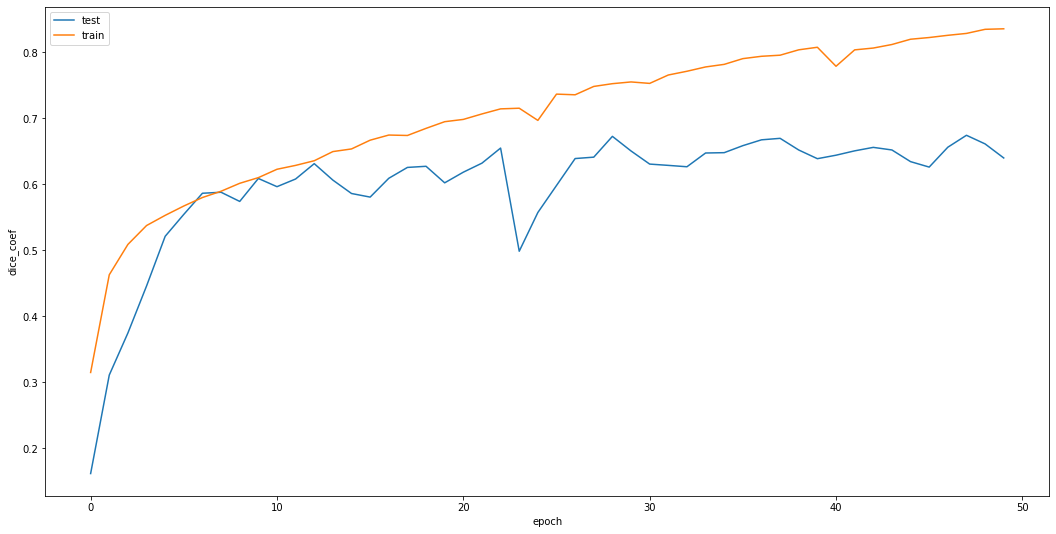

In [145]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Метрика на тесте для данной модели ведет себя более стабильно и в среднем находится на более высоком уровне, чем в изначальной. На поздних этапах снова заметно переобучение.

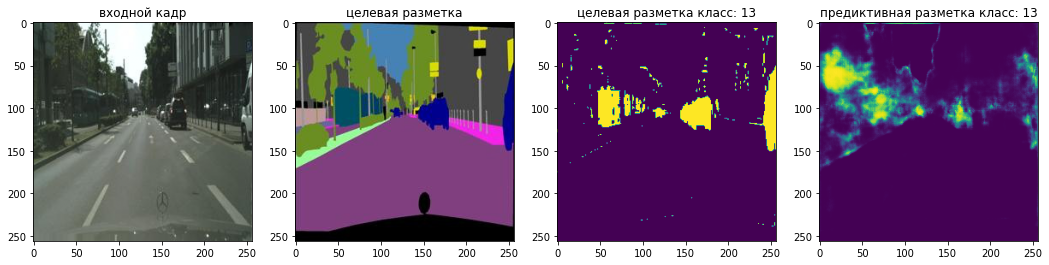

In [146]:
pred = model_2.predict(X_val)

class_ = 13
fig, axes = plt.subplots(1, 4, figsize=(18, 9))
axes[0].imshow(X_val[5])
axes[0].title.set_text('входной кадр')
axes[1].imshow(y_val[5])
axes[1].title.set_text('целевая разметка')
axes[2].imshow(val_labels[5][:,:,class_])
axes[2].title.set_text('целевая разметка класс: '+str(class_))
axes[3].imshow(pred[5][:,:,class_])
axes[3].title.set_text('предиктивная разметка класс: '+str(class_))
plt.show()

Сделаем еще одну итерацию модели - поменяем количество ядер, добавим еще одну пару слоев и, наконец, увеличим размер батча.

In [166]:
def Unet(num_classes = 19, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_3_out) 

    # Block 4
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_4_out)

#     Block 5
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

#     UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # слой классификатор
    x = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=SGD(learning_rate=1e-2),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [167]:
model_3 = Unet(19, (256, 256, 3))

# plot_model(model_3, to_file='model_3.png', show_shapes=True)

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 32) 896         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_440 (BatchN (None, 256, 256, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_440 (Activation)     (None, 256, 256, 32) 0           batch_normalization_440[0][0]    
___________________________________________________________________________________________

In [168]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('seg_model_3.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience)
    callbacks_list=[checkpoint, early]
    return callbacks_list


history = model_3.fit(X_train, train_labels, epochs=50, batch_size=2, validation_data=(X_val, val_labels), callbacks=callbacks())

Epoch 1/50
40/40 [==============================] - 6s 98ms/step - loss: 2.4590 - dice_coef: 0.1693 - val_loss: 2.7243 - val_dice_coef: 0.0713

Epoch 00001: loss improved from inf to 2.45905, saving model to seg_model_3.h5
Epoch 2/50
40/40 [==============================] - 3s 77ms/step - loss: 1.8463 - dice_coef: 0.3153 - val_loss: 2.4592 - val_dice_coef: 0.1453

Epoch 00002: loss improved from 2.45905 to 1.84629, saving model to seg_model_3.h5
Epoch 3/50
40/40 [==============================] - 3s 79ms/step - loss: 1.5380 - dice_coef: 0.3939 - val_loss: 2.5699 - val_dice_coef: 0.2364

Epoch 00003: loss improved from 1.84629 to 1.53801, saving model to seg_model_3.h5
Epoch 4/50
40/40 [==============================] - 3s 74ms/step - loss: 1.3359 - dice_coef: 0.4637 - val_loss: 2.7273 - val_dice_coef: 0.2935

Epoch 00004: loss improved from 1.53801 to 1.33590, saving model to seg_model_3.h5
Epoch 5/50
40/40 [==============================] - 3s 75ms/step - loss: 1.2524 - dice_coef: 0.4

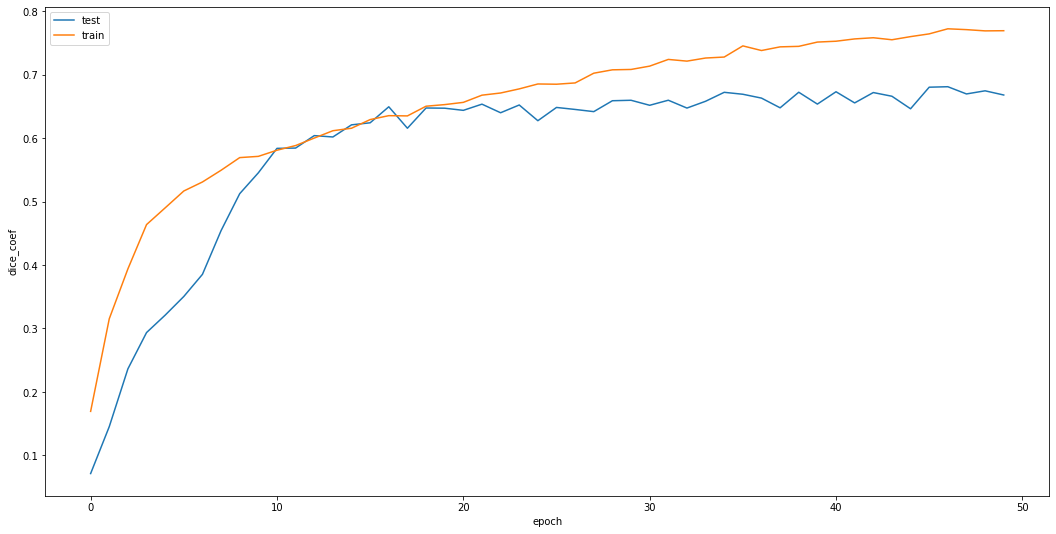

In [169]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

По моему мнению эта модель лучше предыдущих, метрика на тесте довольно стабильна, переобучение значительно сократилось. Из негативных факторов возросшое количество параметров для обучения.

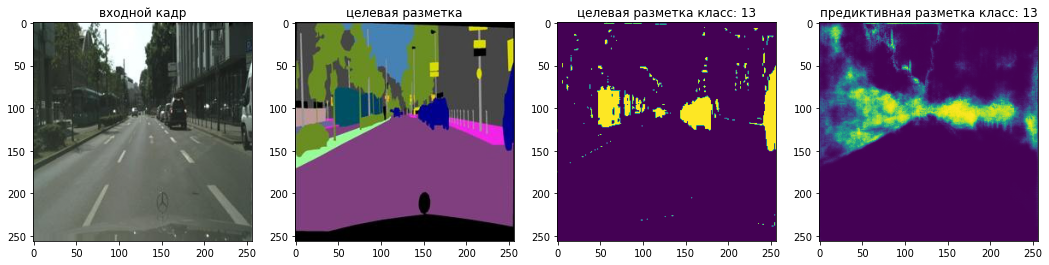

In [170]:
pred = model_3.predict(X_val)

class_ = 13
fig, axes = plt.subplots(1, 4, figsize=(18, 9))
axes[0].imshow(X_val[5])
axes[0].title.set_text('входной кадр')
axes[1].imshow(y_val[5])
axes[1].title.set_text('целевая разметка')
axes[2].imshow(val_labels[5][:,:,class_])
axes[2].title.set_text('целевая разметка класс: '+str(class_))
axes[3].imshow(pred[5][:,:,class_])
axes[3].title.set_text('предиктивная разметка класс: '+str(class_))
plt.show()

Итоговые результаты тестирования разных моделей:

|   | Параметры | Эпохи  | Train_Loss  | Val_loss  | Train_dice_coeff | Val_dice_coeff |
|---|---|---|---|---|---|---|
| Модель 1  | 10,674,259  | 25  |  0.6945 | 1.3464 | 0.6989  | 0.5630  |
| Модель 2  |  10,674,259 | 50  |  **0.3564** | 1.1708 | **0.8359**  | 0.6401  |
| Модель 3  | 17,407,155  | 50  |  0.5261 | **0.9735** | 0.7693  | **0.6679**  |